In [1]:
!pip install -e ..
import nextbike as nb
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import geopandas 
from geopandas.tools import sjoin
import geoplot
from keras.utils.np_utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

Obtaining file:///C:/Users/meikh/Dropbox/Programming%20Data%20Science/PDS2020_Herber
  Attempting uninstall: PDS2020-Herber
    Found existing installation: PDS2020-Herber 0.0.1
    Uninstalling PDS2020-Herber-0.0.1:
      Successfully uninstalled PDS2020-Herber-0.0.1
  Running setup.py develop for PDS2020-Herber


Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
c:\users\meikh\miniconda3\envs\pds_herber\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Declare name of the first csv-file
csv_name = "dortmund"
# Load dataset
path_a = Path(os.getcwd()).parent
path=os.path.join(path_a, f'data\input\{csv_name}_preprocessed.csv')
df = nb.input_output.read_file(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242878 entries, 0 to 242877
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   p_spot_start          242878 non-null  int64  
 1   datetime_start        242878 non-null  object 
 2   b_number              242878 non-null  int64  
 3   p_uid_start           242878 non-null  int64  
 4   p_bikes_start         242878 non-null  int64  
 5   p_lat_start           242878 non-null  float64
 6   b_bike_type           242878 non-null  int64  
 7   p_name_start          242878 non-null  object 
 8   p_number_start        242878 non-null  int64  
 9   p_lng_start           242878 non-null  float64
 10  p_bike_start          242878 non-null  int64  
 11  p_spot_end            242878 non-null  int64  
 12  datetime_end          242878 non-null  object 
 13  p_uid_end             242878 non-null  float64
 14  p_bikes_end           242878 non-null  float64
 15  

# Descriptive Statistics

### Duration per Month

In [3]:
reduced_df = df[['duration', 'month_start']]
pd.pivot_table(reduced_df, values='duration', index='month_start', aggfunc={'duration': [np.mean, np.std, max]})

,max,mean,std
month_start,,,
1,1067.0,65.337130,132.097966
2,1330.0,35.485086,94.348206
3,1385.0,41.207761,98.536873
4,1305.0,44.579629,99.816857
5,1275.0,52.117602,110.819237
6,1345.0,42.522168,96.241462
8,1348.0,34.757147,79.857753
9,943.0,19.833606,49.832261
10,1384.0,17.836654,44.529966


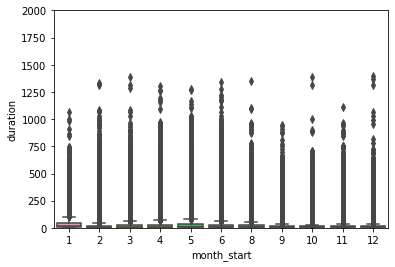

In [4]:
ax = sns.boxplot(x='month_start', y='duration', data=reduced_df)
ax.set(ylim=(0, 2000))
plt.show(ax)

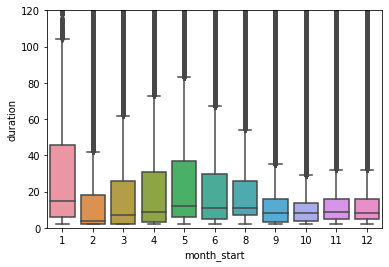

In [5]:
ax = sns.boxplot(x='month_start', y='duration', data=reduced_df)
ax.set(ylim=(0, 120))
plt.show(ax)

Not looking at January, trip duration is highest during the summer months and shows a quadratic or cubic development over the year. January does not fit into this pattern by having the highest average duration which seems not to be caused by outliers. It remains unclear, whether the January 2019 observations are biased or due to real special circumstances, but in a multi-year dataset this month in this year would receive a dummy to account for this. This will be done here as well.

In [6]:
# datetime is a string again, convert it again to datetime format
df['datetime_start'] = df['datetime_start'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# Create a dummy for January 2019
df['january_19'] = df['datetime_start'].apply(lambda x: 1 if (x.month == 1) else 0)
# Create variables for linear, quadratic and cubic form of the day of the year
df['day'] = df['datetime_start'].apply(lambda x: x.timetuple().tm_yday)
df['day_square'] = df['datetime_start'].apply(lambda x: x.timetuple().tm_yday**2)
df['day_cubic'] = df['datetime_start'].apply(lambda x: x.timetuple().tm_yday**3)

### Duration per Day of Week

In [7]:
reduced_df = df[['duration', 'day_of_week_start']]
pd.pivot_table(reduced_df, values='duration', index='day_of_week_start', aggfunc={'duration': [np.mean, np.std, max]})

,max,mean,std
day_of_week_start,,,
0,1317.0,28.306523,69.725544
1,1094.0,34.097058,82.818292
2,1368.0,30.908643,77.783246
3,1277.0,29.998247,76.658169
4,1330.0,31.611458,76.934791
5,1385.0,33.814241,87.703347
6,1399.0,29.549734,85.134242


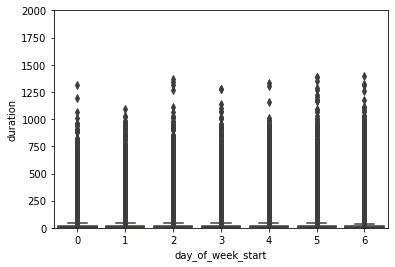

In [8]:
ax = sns.boxplot(x='day_of_week_start', y='duration', data=reduced_df)
ax.set(ylim=(0, 2000))
plt.show(ax)

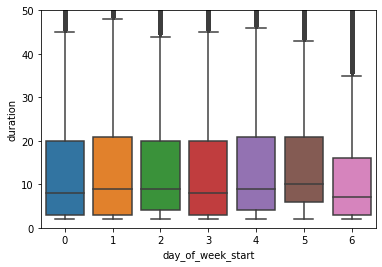

In [9]:
ax = sns.boxplot(x='day_of_week_start', y='duration', data=reduced_df)
ax.set(ylim=(0, 50))
plt.show(ax)

The trip duration per day of the week does not show high differences between the days. Saturday shows the highest value while Sunday has the lowest. Every day of the week will just get a dummy.

### Duration per Hour of Day

In [10]:
reduced_df = df[['duration', 'hour_start']]
pd.pivot_table(reduced_df, values='duration', index='hour_start', aggfunc={'duration': [np.mean, np.std, max]})

,max,mean,std
hour_start,,,
0,1399.0,52.952400,155.781560
1,1348.0,53.392692,143.460109
2,1257.0,32.001027,118.416028
3,1154.0,23.583954,90.465210
4,1144.0,49.476168,141.474175
5,1100.0,63.048385,132.277420
6,1029.0,54.497066,121.681233
7,1007.0,52.777766,112.993470
8,947.0,41.992326,94.387003


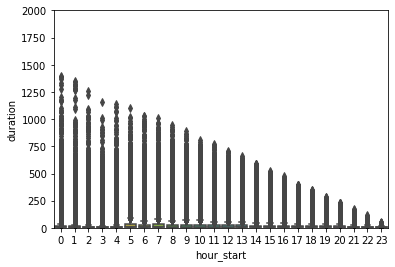

In [11]:
ax = sns.boxplot(x='hour_start', y='duration', data=reduced_df)
ax.set(ylim=(0, 2000))
plt.show(ax)

That this dataset only includes trips which end at the same day as they started was already discussed at the end of the last notebook. 

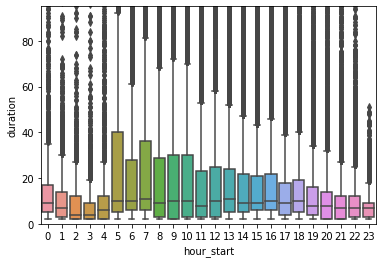

In [12]:
ax = sns.boxplot(x='hour_start', y='duration', data=reduced_df)
ax.set(ylim=(0, 95))
plt.show(ax)

Trip duration is lowest at night, with a sharp increase in the early morning. It is likely that the trip duration will be modelled well by the time of the day with a polynomial function.

In [13]:
# Create variables for quadratic and cubic form of the minutes of the day
df['daytime_in_min_square'] = df['daytime_in_min_start'].apply(lambda x: x**2)
df['daytime_in_min_cubic'] = df['daytime_in_min_start'].apply(lambda x: x**3)

### Duration by bike type

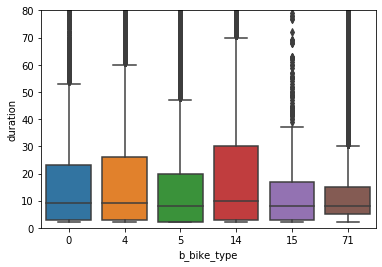

In [14]:
ax = sns.boxplot(x='b_bike_type', y='duration', data=df)
ax.set(ylim=(0, 80))
plt.show(ax)

The data contains different bike types and they seem to be associated with the trip duration.

# Visualizations with Georeferenced Data

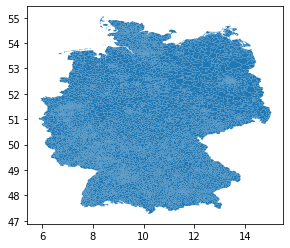

In [15]:
# Load PLZ numbers
plz_path = os.path.join(path_a, "data\input\plz-gebiete\plz-gebiete.shp")
plz_geo_df = geopandas.read_file(plz_path)
# Choose projection
plz_geo_df.crs = 'EPSG:25832'
plz_geo_df.plot()

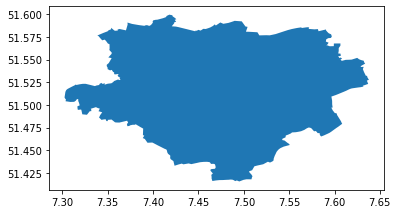

In [16]:
# Load boundaries of Dortmund
dortmund_path = os.path.join(path_a, "data\input\Dortmund\landkreise-in-germany.shp")
dortmund_geo_df = geopandas.read_file(dortmund_path)
dortmund_geo_df = dortmund_geo_df[['geometry']]
dortmund_geo_df.crs = 'EPSG:25832'
ax = dortmund_geo_df.plot()

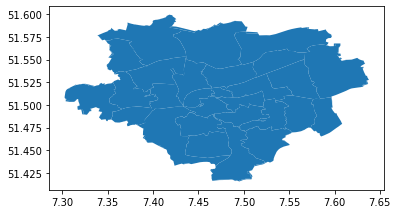

In [17]:
# Intersect the postal codes with the boundaries of Dortmund
plz_geo_df = geopandas.overlay(dortmund_geo_df, plz_geo_df, how='intersection')
plz_geo_df.drop(['note'], axis = 1, inplace = True)
plz_geo_df.plot()

In [18]:
# Create geometric starting points and connect to the plz data
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.p_lng_start, df.p_lat_start))
gdf.crs = 'EPSG:25832'
gdf = gdf.rename(columns={'geometry': 'point_start'}).set_geometry('point_start')
# Remove starting points outside Dortmund
gdf = sjoin(gdf, plz_geo_df, op='within')
gdf.drop(['index_right'], axis = 1, inplace = True)
gdf.rename(columns={'plz':'plz_start'}, inplace=True)
# The same for the end of the trips
gdf = geopandas.GeoDataFrame(gdf, geometry=geopandas.points_from_xy(gdf.p_lng_end, gdf.p_lat_end))
gdf.crs = 'EPSG:25832'
gdf = gdf.rename(columns={'geometry': 'point_end'}).set_geometry('point_end')
gdf = sjoin(gdf, plz_geo_df, op='within')
gdf.drop(['index_right'], axis = 1, inplace = True)
gdf.rename(columns={'plz':'plz_end'}, inplace=True)
# Set the geometry back to the starting points
gdf = gdf.set_geometry('point_start')

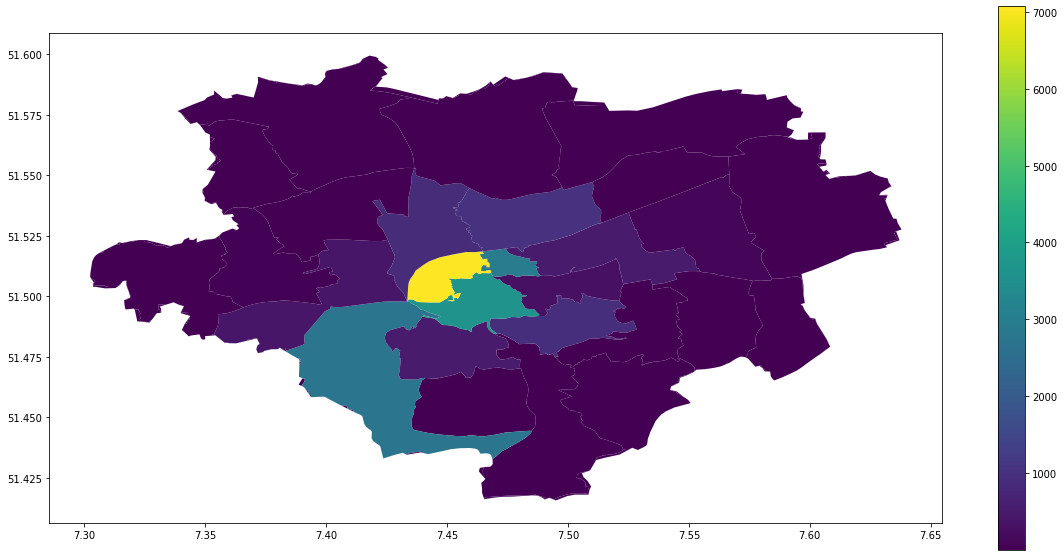

In [19]:
# Choropleth of started trips per plz region in May 2019
may_plz = (gdf['plz_start'][gdf.month_start == 5].value_counts()).to_frame()
may_plz = pd.merge(plz_geo_df, may_plz, how='left', left_on='plz', right_index=True)
may_plz.plot(column='plz_start', legend=True, figsize=(20, 10))

In May 2019 almost all trips in Dortmund started in or around the city centre.

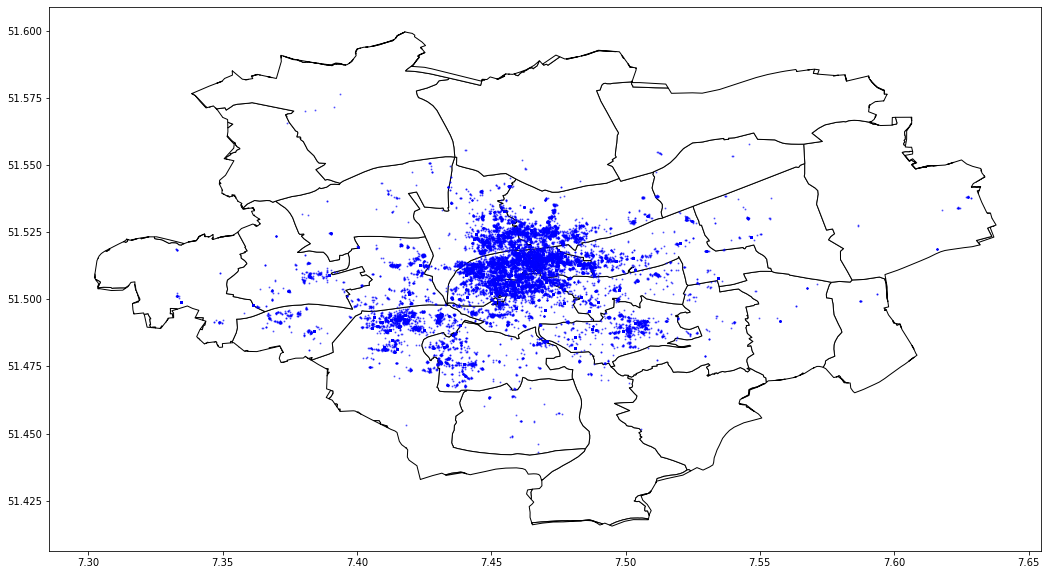

In [20]:
# Show all bike stations
base = plz_geo_df.plot(color='white', edgecolor='black', figsize=(20, 10))
gdf.plot(ax=base, marker='o', color='blue', markersize=1, alpha=0.5)

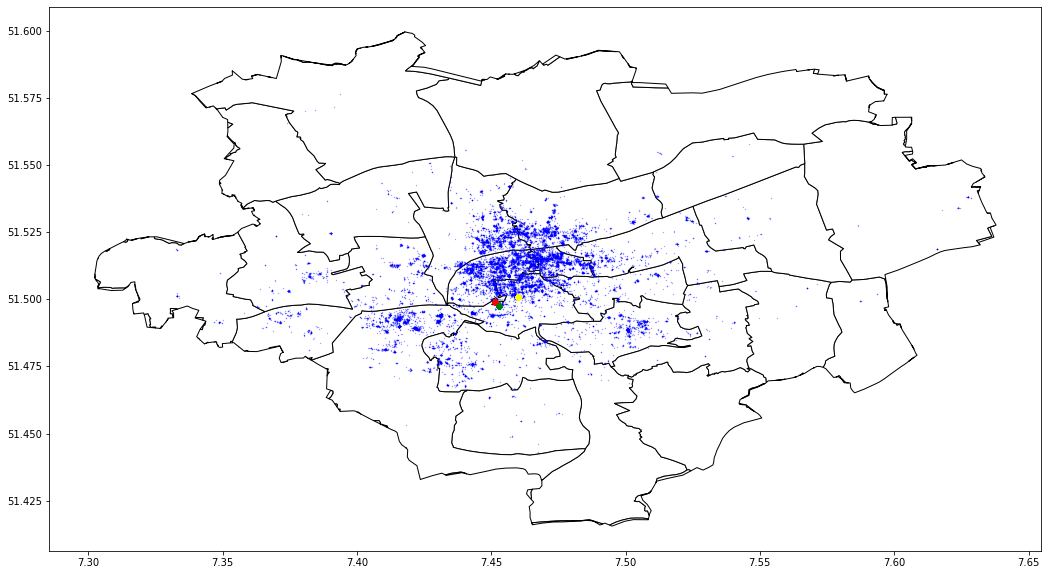

In [21]:
# Check whether p_number is clustering bike stations
base = plz_geo_df.plot(color='white', edgecolor='black', figsize=(20, 10))
gdf[gdf.p_number_start == 0].plot(ax=base, marker='o', color='blue', markersize=0.1, alpha=0.5)
gdf[gdf.p_number_start == 7300].plot(ax=base, marker='o', color='red', markersize=20)
gdf[gdf.p_number_start == 7350].plot(ax=base, marker='o', color='yellow', markersize=20)
gdf[gdf.p_number_start == 7729].plot(ax=base, marker='o', color='green', markersize=20)

In [22]:
# Check if the p_numbers are associated with only one station name
print(gdf['p_name_start'][gdf.p_number_start == 7350].unique(), 
      gdf['p_name_start'][gdf.p_number_start == 7300].unique(), 
      gdf['p_name_start'][gdf.p_number_start == 7729].unique())

['Polizeipräsidium'] ['Steigenberger Hotel / Berswordtstr.'] ['DEKT - Westfalenhallen']


It seems that my assumptions on p_number were wrong. Every p_number stands for a bike station, except for p_number 0 which includes all cases where a start or end is not associated with a bike station.

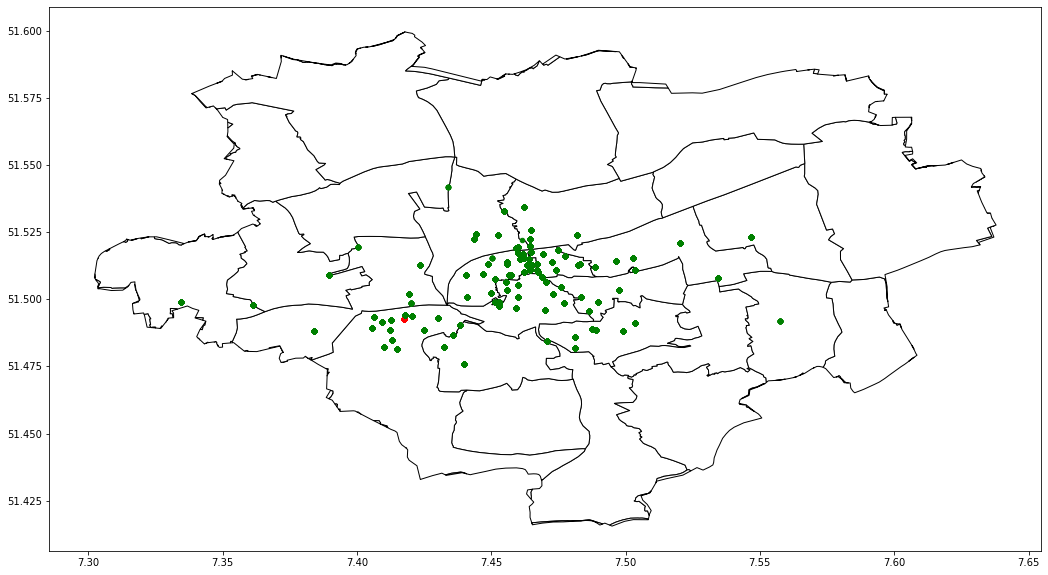

In [23]:
# Show bike stations and mark the university red
base = plz_geo_df.plot(color='white', edgecolor='black', figsize=(20, 10))
gdf[gdf.p_name_start == 'Universität/S-Bahnhof'].plot(ax=base, marker='o', color='red', markersize=20)
gdf[(gdf.p_name_start != 'Universität/S-Bahnhof') & (gdf.p_number_start != 0)].plot(ax=base, marker='o', color='green', markersize=20)

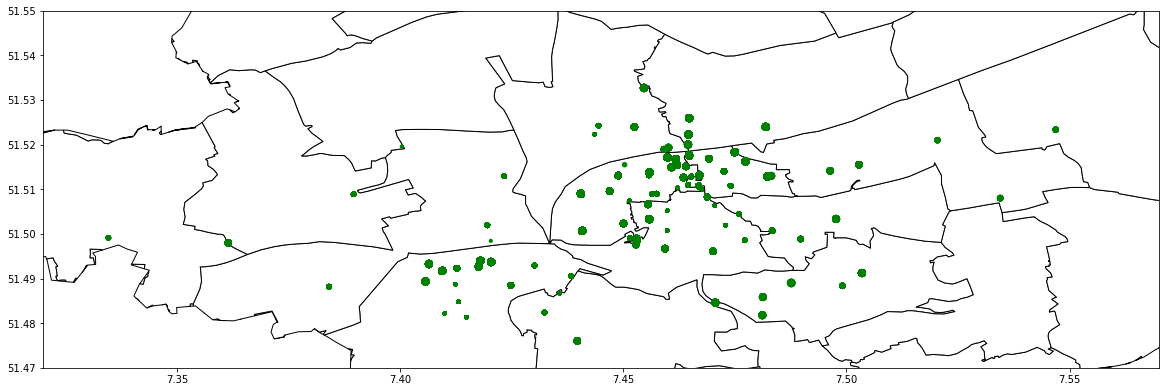

In [24]:
# Calculate the number of bikes at bike stations on 01.05.2019 at 12 AM.
gdf.reset_index(drop=True, inplace=True)
stations = gdf['p_number_start'].unique()
stations_frame = pd.Series(stations).to_frame()
stations_frame['bikes'] = np.nan
stations_frame = stations_frame.rename(columns={0: 'station'})
stations = stations.tolist()
stations.remove(0)
i = 0
while (i<=439): # These are the observations until the 1st May
    stations_frame['bikes'][stations_frame.station == gdf.p_number_end[i]] = gdf.p_bikes_end[i]
    if(gdf.p_number_end[i] in stations): stations.remove(gdf.p_number_end[i])
    i = i+1
while (stations):
    if(gdf.p_number_start[i] in stations):
        stations_frame['bikes'][stations_frame.station == gdf.p_number_start[i]] = gdf.p_bikes_start[i]
        stations.remove(gdf.p_number_start[i])
    i = i+1
# Merge with the main dataset and plot it
may_stations = pd.merge(gdf[['p_number_start', 'point_start']][gdf.p_number_start!=0], stations_frame, how='left', left_on='p_number_start', right_on='station')
base = plz_geo_df.plot(color='white', edgecolor='black', figsize=(20, 10))
base.set_xlim(7.32, 7.57)
base.set_ylim(51.47, 51.55)
may_stations.iloc[ :50000 , : ].plot(ax=base, marker='o', color='green', markersize=may_stations['bikes']*10)

This is by far not the sexiest possible visualization, but the sizes of the points show how many bikes were at every station on May 1st.

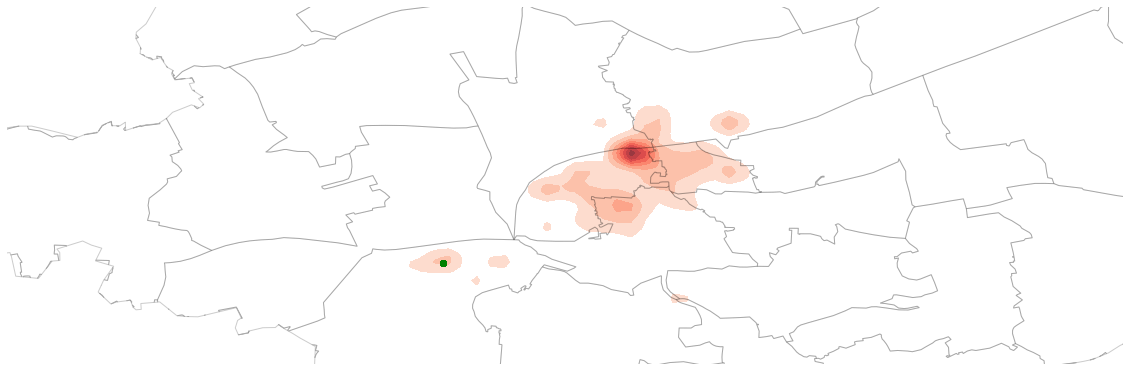

In [25]:
## Compare starting areas at different daytimes in heatmaps (the university is at the green point)
# Here: between 7 and 8 AM
base = geoplot.kdeplot(gdf['point_start'][gdf.hour_start == 7], cmap='Reds', shade=True, shade_lowest=False, figsize=(20, 10))
base.set_xlim(7.32, 7.57)
base.set_ylim(51.47, 51.55)
plz_geo_df.plot(ax=base, color='white', edgecolor='black', alpha=0.2)
gdf[gdf.p_name_start == 'Universität/S-Bahnhof'].plot(ax=base, marker='o', color='green', markersize=30)

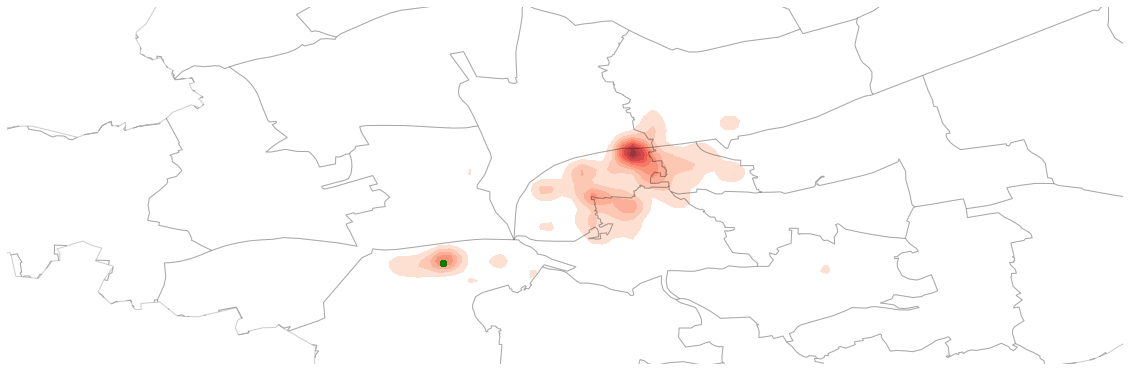

In [26]:
# Here: between 4 and 5 PM
base = geoplot.kdeplot(gdf['point_start'][gdf.hour_start == 16], cmap='Reds', shade=True, shade_lowest=False, figsize=(20, 10))
base.set_xlim(7.32, 7.57)
base.set_ylim(51.47, 51.55)
plz_geo_df.plot(ax=base, color='white', edgecolor='black', alpha=0.2)
gdf[gdf.p_name_start == 'Universität/S-Bahnhof'].plot(ax=base, marker='o', color='green', markersize=30)

A comparison of the two heatmaps reveals that starts of bike trips are in the afternoon more concentrated at the university than in the morning. 

# Preparation for prediction tasks

In [27]:
# Calculate distance to the centre of all start locations
gdf.set_geometry('point_start')
gdf['lat_mean'] = gdf['p_lat_start'].mean()
gdf['lng_mean'] = gdf['p_lng_start'].mean()
gdf['centre_point'] = geopandas.points_from_xy(gdf['lng_mean'], gdf['lat_mean'])
gdf['distance_to_centre'] = ((gdf.set_geometry('centre_point'))['centre_point'].distance((gdf.set_geometry('point_start'))['point_start'])).apply(lambda x: x*1000)

The calculated distance is the eucledian distance between the geometric points and does not represent a unit as meter or kilometer.

In [28]:
# Calculate distance of all start locations to the university
gdf.set_geometry('point_start')
gdf['lat_uni'] = gdf['p_lat_start'][gdf.p_name_start == 'Universität/S-Bahnhof'].iloc[0]
gdf['lng_uni'] = gdf['p_lng_start'][gdf.p_name_start == 'Universität/S-Bahnhof'].iloc[0]
gdf['uni_point'] = geopandas.points_from_xy(gdf['lng_uni'], gdf['lat_uni'])
gdf['distance_to_uni_start'] = ((gdf.set_geometry('uni_point'))['uni_point'].distance((gdf.set_geometry('point_start'))['point_start'])).apply(lambda x: x*1000)
# ... and of all end locations to university
gdf['distance_to_uni_end'] = ((gdf.set_geometry('uni_point'))['uni_point'].distance((gdf.set_geometry('point_end'))['point_end'])).apply(lambda x: x*1000)
# ... and whether a trip is towards university
gdf['towards_uni'] = (gdf['distance_to_uni_start'] > gdf['distance_to_uni_end']).apply(lambda x: int(x))

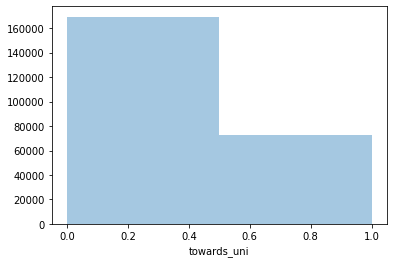

In [29]:
sns.distplot(gdf['towards_uni'], kde=False, bins=2)

About 70% of the trips are towards university

In [30]:
# Drop variables not necessary for prediction
gdf.drop(['p_spot_start', 'datetime_start', 'b_number', 'p_uid_start', 
          'p_bikes_start', 'p_lat_start', 'p_name_start', 'p_lng_start', 'p_bike_start', 
          'p_spot_end', 'datetime_end', 'p_uid_end', 'p_bikes_end', 'p_lat_end', 'p_name_end', 
          'p_number_end', 'p_lng_end', 'p_bikes_end', 'p_bike_end', 'hour_start', 'weekend_start', 
          'point_start', 'plz_start', 'point_end', 'plz_end', 'lat_mean', 'lng_mean', 
          'centre_point', 'lat_uni', 'lng_uni', 'uni_point', 'distance_to_uni_end', 'month_start'
          ], axis = 1, inplace = True)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 242058 entries, 0 to 242057
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   b_bike_type            242058 non-null  int64  
 1   p_number_start         242058 non-null  int64  
 2   duration               242058 non-null  int64  
 3   daytime_in_min_start   242058 non-null  int64  
 4   day_of_week_start      242058 non-null  int64  
 5   january_19             242058 non-null  int64  
 6   day                    242058 non-null  int64  
 7   day_square             242058 non-null  int64  
 8   day_cubic              242058 non-null  int64  
 9   daytime_in_min_square  242058 non-null  int64  
 10  daytime_in_min_cubic   242058 non-null  int64  
 11  distance_to_centre     242058 non-null  float64
 12  distance_to_uni_start  242058 non-null  float64
 13  towards_uni            242058 non-null  int64  
dtypes: float64(2), int64(12)
mem

The prediction of the trip duration and whether a trip heads towards university will be predicted by the type of the bike, the start location, the daytime, the day of the week and the year and the distances of the start location to the university and to the centre of all start locations.

### Dichotomizing the nominal variables

In [31]:
# b_bike_type
for i in gdf['b_bike_type'].unique():
    gdf['b_bike_type'].replace({i: 'b_bike_type'+str(i)}, inplace = True) 
dummy = pd.get_dummies(gdf['b_bike_type'])
gdf = pd.concat([gdf, dummy], axis=1)
# p_number_start
for i in gdf['p_number_start'].unique():
    gdf['p_number_start'].replace({i: 'p_number_start'+str(i)}, inplace = True) 
dummy = pd.get_dummies(gdf['p_number_start'])
gdf = pd.concat([gdf, dummy], axis=1)
# day_of_week_start
for i in gdf['day_of_week_start'].unique():
    gdf['day_of_week_start'].replace({i: 'day_of_week_start'+str(i)}, inplace = True) 
dummy = pd.get_dummies(gdf['day_of_week_start'])
gdf = pd.concat([gdf, dummy], axis=1)
gdf.drop(['b_bike_type', 'p_number_start', 'day_of_week_start'], axis = 1, inplace = True)

In [32]:
# Save the preprocessed dataset for regression
path=os.path.join(path_a, f'data\input\{csv_name}_preprocessed_regression.csv')
gdf2 = gdf.drop(['towards_uni'], axis = 1)
gdf2.to_csv(path)
# ... and for classification
path=os.path.join(path_a, f'data\input\{csv_name}_preprocessed_classification.csv')
gdf2 = gdf.drop(['duration'], axis = 1)
gdf2.to_csv(path)